# Cleand vs Dirty plates

## Problem Statement

We have a limited training dataset consisting of 20 images of clean plates and 20 images of dirty plates, along with a considerably larger test dataset. Our objective is to utilize this training dataset to develop a robust model capable of classifying images of plates as either clean or dirty.

## Data Preprocessing and EDA

### Import libraries

In [1]:
import zipfile
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.python.keras.callbacks import EarlyStopping
import pandas as pd
import random

2024-06-16 00:55:22.893371: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-16 00:55:22.893500: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-16 00:55:23.022607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Unzip the original file

In [2]:
# Original zip file path
zip_file_path = '/kaggle/input/platesv2/plates.zip'

# Unzip the original file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('plates_data')

# The file path of the train and test images
train_path = '/kaggle/working/plates_data/plates/train'
test_path = '/kaggle/working/plates_data/plates/test'

### Load and visualize some sample train images

In [3]:
# define a function to load and visualize some images
def load_and_visualize_images(image_dir, num_images_per_class = 3):
    class_names = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
    plt.figure(figsize=(10, 10))
    plt.figure(figsize=(10, 10))
    image_count = 0
    total_images = num_images_per_class * len(class_names)

    for class_name in class_names:
        class_path = os.path.join(image_dir, class_name)
        print(class_path)
        image_paths = [os.path.join(class_path, img) 
                       for img in os.listdir(class_path)
                       if img.endswith(('.png', '.jpg', '.jpeg'))][:num_images_per_class]
        
        for image_path in image_paths:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(len(class_names),num_images_per_class, image_count+1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis('off')
            image_count += 1
    plt.show()

#### Call the load_and_visualize_images to show sample images

/kaggle/working/plates_data/plates/train/dirty
/kaggle/working/plates_data/plates/train/cleaned


<Figure size 1000x1000 with 0 Axes>

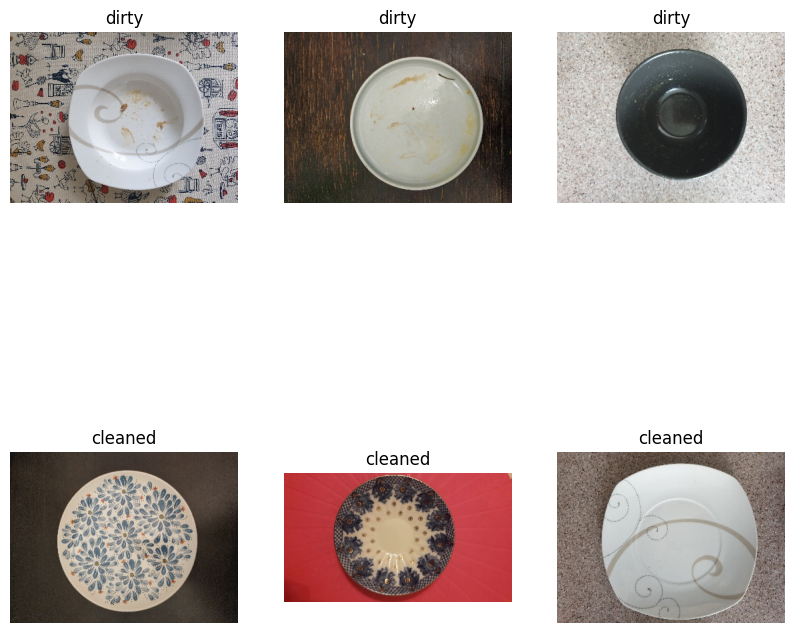

In [4]:
load_and_visualize_images(train_path)

### Check the balance of the classes 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


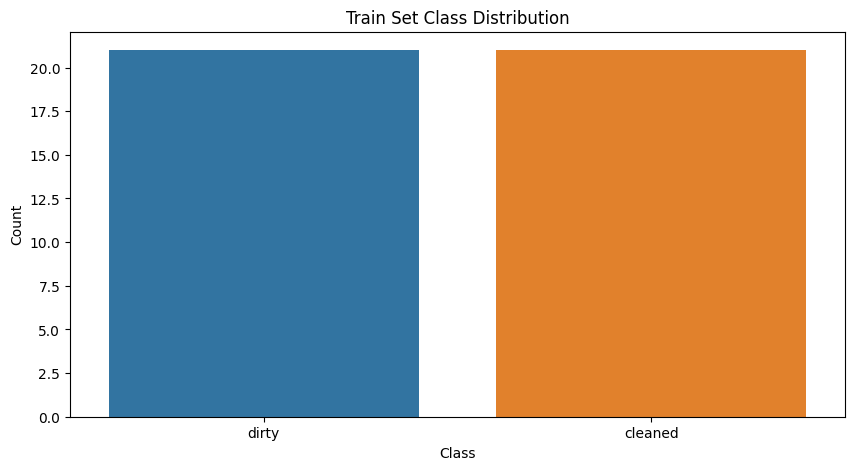

In [5]:
# Count the nums of images for each class.
def count_images(image_dir):
    class_counts = {}
    class_names = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
    for class_name in class_names:
        class_path = os.path.join(image_dir, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(train_path)

def plot_class_distribution(counts, title):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()))
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(train_counts, 'Train Set Class Distribution')

### Check the dimensions of the images

In [6]:
# Check the image dimensions
def check_image_dimensions(image_dir, is_direct_dir = False):
    dimensions = set()
    if is_direct_dir:
        image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir)]
        for image_path in image_paths:
            img = cv2.imread(image_path)
            if img is not None:
                dimensions.add(img.shape)
        return dimensions
    
    class_names = [d for d in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, d))]
    for class_name in class_names:
        class_path = os.path.join(image_dir, class_name)
        image_paths = [os.path.join(class_path, img) for img in os.listdir(class_path)]
        for image_path in image_paths:
            img = cv2.imread(image_path)
            if img is not None:
                dimensions.add(img.shape)
    return dimensions

train_dimensions = check_image_dimensions(train_path)
test_dimensions = check_image_dimensions(test_path, True)

print("Train set unique image dimensions:", train_dimensions)
print("Test set unique image dimensions:", test_dimensions)

Train set unique image dimensions: {(341, 256, 3), (454, 256, 3), (455, 256, 3), (256, 454, 3), (256, 341, 3), (256, 342, 3)}
Test set unique image dimensions: {(341, 256, 3), (454, 256, 3), (256, 454, 3), (256, 341, 3), (256, 342, 3)}


## Model Creation

#### Define some basic settings

We've noted that the images vary in size, so it's essential to standardize them to a uniform dimension. Since the size (224,224) works well for pre-trained model EfficientNetB0, which we will use later, I will resize them to (224,224).

In [7]:
# The resized uniform image dimensions
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

# Batch size
BATCH_SIZE = 4

# numbers of epochs
EPOCHS = 50

# EarlyStopper
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 6, restore_best_weights=True)

#### Data augmentation for training data

In [8]:
# Data augmentaion for training data
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split = 0.2,
)

### Training generator and validation generator

In [9]:
# Training generator with augmentation and repetition
train_generator = train_datagen.flow_from_directory(
    train_path, 
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    keep_aspect_ratio = True,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle = True
)

# Validation generator (no augmentation)
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    keep_aspect_ratio = True,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset = 'validation',
    shuffle = False
)

Found 32 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


### Build a CNN model

In [10]:
# Load the EfficientNetB0 model with custom input size and without the top fully connected layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
# Create a new model and add the VGG16 base model
model = Sequential()
model.add(base_model)

# Add new convolutional layers on top of the base model
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(GlobalAveragePooling2D())  # Add a global average pooling layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))  # Use sigmoid for binary classification

# Freeze the base model layers to prevent them from being updated during the initial training
base_model.trainable = False

# Compile the model
model.compile(optimizer = Adam(learning_rate = 0.0001), loss='binary_crossentropy', metrics=['binary_accuracy'])


### Train the model

#### Train the model by using the pre-trained base model

In [12]:
history = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = validation_generator,
    callbacks = [cb_early_stopper]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - binary_accuracy: 0.5150 - loss: 0.6829 

I0000 00:00:1718499375.149198     125 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 ━━━━━━━━━━━━━━━━━━━━ 43s 921ms/step - binary_accuracy: 0.4812 - loss: 0.7132 - val_binary_accuracy: 0.5000 - val_loss: 0.6848
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.3057 - loss: 0.7105 - val_binary_accuracy: 0.5000 - val_loss: 0.6644
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - binary_accuracy: 0.4502 - loss: 0.7854 - val_binary_accuracy: 0.6250 - val_loss: 0.6873
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - binary_accuracy: 0.6757 - loss: 0.6419 - val_binary_accuracy: 0.7500 - val_loss: 0.6211
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - binary_accuracy: 0.7460 - loss: 0.5746 - val_binary_accuracy: 0.5000 - val_loss: 0.5837
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - binary_accuracy: 0.7622 - loss: 0.5785 - val_binary_accuracy: 0.7500 - val_loss: 0.5240
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - binary_accuracy: 0.9270 - loss: 0.4064 - val_binary_accuracy: 1.0000 - val_loss: 0.4141
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 

#### Unfreeze some of the base model layers for fine-tuning

In [13]:
# Unfreeze some of the base model layers for fine-tuning
base_model.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])

# Fine-tune the model
history_fine = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks = [cb_early_stopper]
)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 91s 787ms/step - binary_accuracy: 0.7503 - loss: 0.5626 - val_binary_accuracy: 0.8750 - val_loss: 0.2708
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - binary_accuracy: 0.7864 - loss: 0.5110 - val_binary_accuracy: 0.7500 - val_loss: 0.3719
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - binary_accuracy: 0.7599 - loss: 0.4837 - val_binary_accuracy: 0.8750 - val_loss: 0.4143
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - binary_accuracy: 0.6182 - loss: 0.6439 - val_binary_accuracy: 0.8750 - val_loss: 0.2576
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - binary_accuracy: 0.7037 - loss: 0.5757 - val_binary_accuracy: 0.8750 - val_loss: 0.3637
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - binary_accuracy: 0.5470 - loss: 0.7735 - val_binary_accuracy: 0.7500 - val_loss: 0.4493
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - binary_accuracy: 0.7235 - loss: 0.5438 - val_binary_accuracy: 0.8750 - val_loss: 0.4415
Epoch 8/50
8/8 ━━━━━━━━━━

#### Show the training process

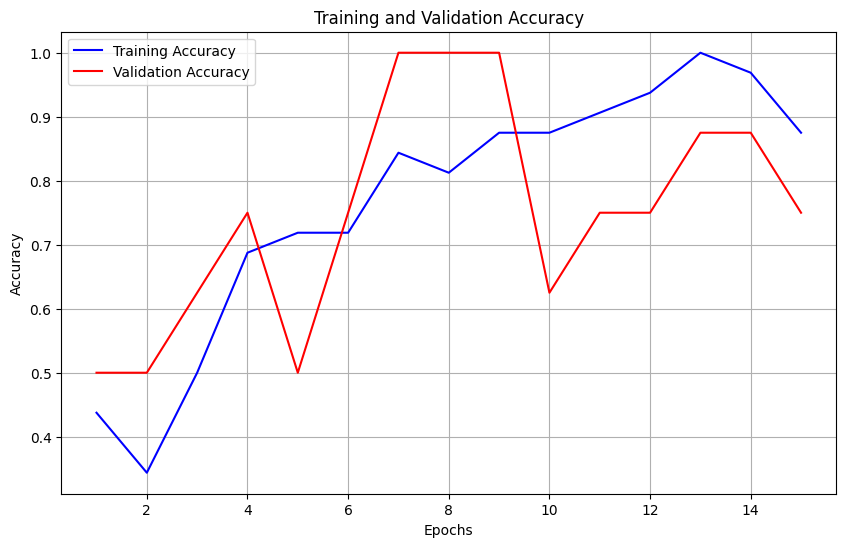

In [14]:
# Extract training history
train_accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Classify the images and Store the ressult

In [15]:
results = []

# Loop for all the images in the test folder
for image_name in os.listdir(test_path):
    if image_name.endswith('.jpg') or image_name.endswith('.png'):
        # Get the image id
        image_id = os.path.splitext(image_name)[0]
        
        # Load the images 
        image_path = os.path.join(test_path, image_name)
        image = load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        
        # Classify the images
        classification = model.predict(image)
        label = 'dirty' if classification[0][0] > 0.5 else 'cleaned'
        
        # Save the result
        results.append({'id': image_id, 'label': label})
        
# Save the result to a csv file
df = pd.DataFrame(results)
df.to_csv('submission.csv', index = False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

## Show the classification result

### Show some sample images and its classification result

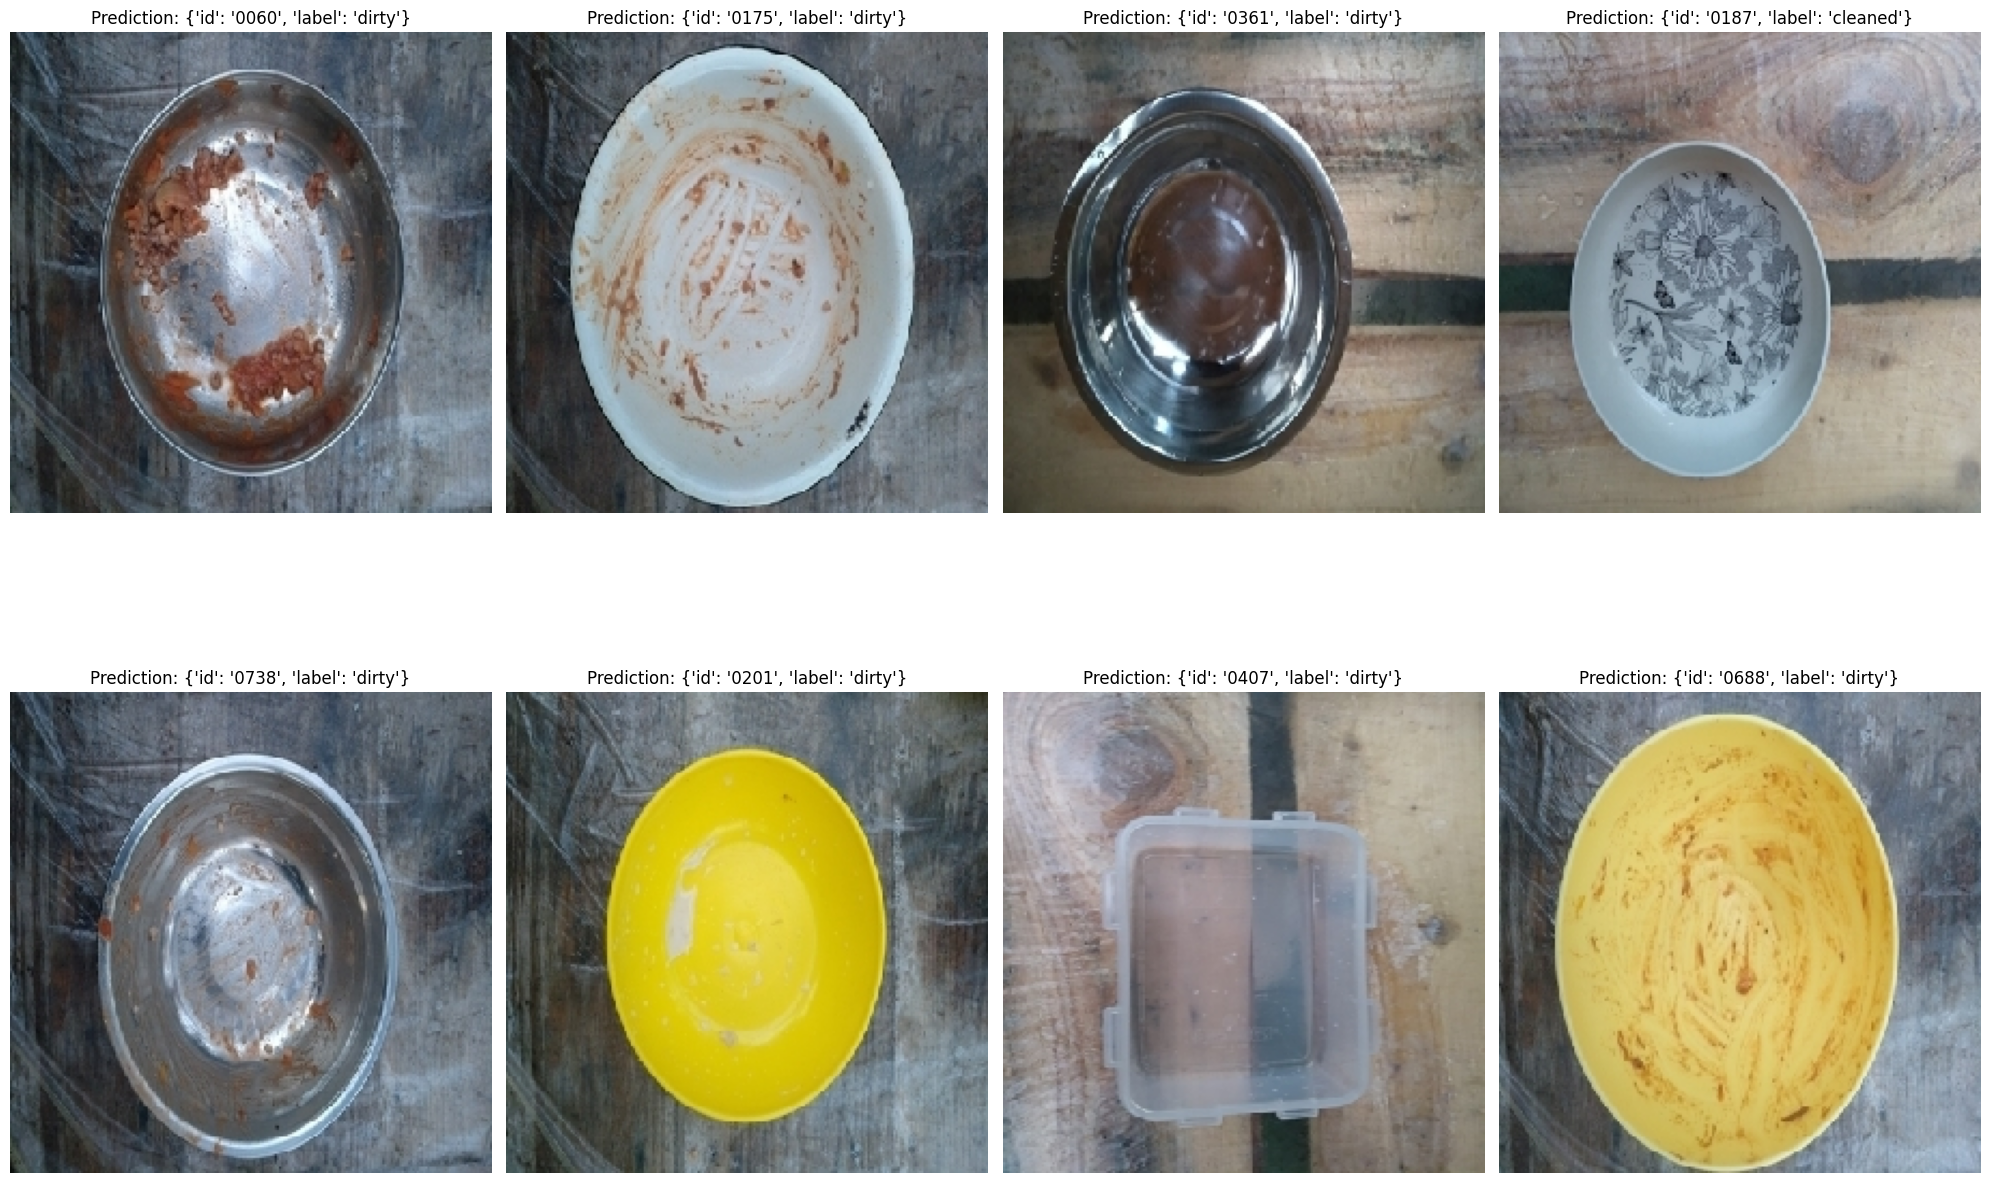

In [18]:
# Get list of image files in the test folder
image_files = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

# Select 8 images to display
num_images_to_display = 8
selected_images = random.sample(image_files, num_images_to_display)

# Prepare to plot the images
plt.figure(figsize=(20, 15))
for i, image_file in enumerate(selected_images):
    image_path = os.path.join(test_path, image_file)
    
    # Load the image
    img = load_img(image_path, target_size=(224, 224))
    
    # Plot the image
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Prediction: {results[i]}')  # Use the stored label
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusion

* This is the final assignment of my deep learning course. I chose this Kaggle competition because I found it interesting, but it turned out to be much more challenging than I anticipated.

* There are two main reasons for this difficulty. First, the training dataset is very small. Second, it is not easy to classify whether a plate is clean or dirty because some plates are only slightly dirty, or they have designs that resemble dirt.

* Therefore, I used the pre-trained EfficientNetB0 model to complete this project. Most of my time was spent on tuning the parameters.

## References

* You can find additional information here [EfficientNetB0](https://keras.io/api/applications/efficientnet/) 